In [ ]:
%matplotlib inline

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB :
  
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Github

  repository= 'keyword_spotting'
  %cd {repository}
  %ls -a
  # CPU:
  #!pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

  # GPU:
  !pip install pydub torch==1.11.0+cu115 torchvision==0.12.0+cu115 torchaudio==0.11.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio,torchvision
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
import metrics.metrics as metrics
from dataset.subsetSC import SubsetSC
from models.spectrogram_model import spectrogram_model
from utilsFunc import *

working_dir=%pwd
if 'PROJET_ESSAI/notebooks' in working_dir :
    print('Wrong working directory')
    %cd ..
    working_dir=%pwd
    print('New directory :',working_dir)

if 'storage' not in locals():   
    storage=dict()

In [ ]:
storage['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using',storage['device'])

## Downloading and setting up the dataset

In [ ]:
with timeThat('training & test sets'):
    root='/content/sample_data' if IN_COLAB else './'
    if 'train_set' not in locals():  
        train_set = SubsetSC("training",root)
    if 'test_set' not in locals():
        test_set = SubsetSC("testing",root)
storage['waveform'], storage['sample_rate'], label, speaker_id, utterance_number = train_set[0]

# TODO : We are doing it without resampling it.
#resample_transform=torchaudio.transforms.Resample(orig_freq=storage['sample_rate'], new_freq=new_sample_rate)

## Let's visualize the data !

In [ ]:
plt.plot(storage['waveform'].t().numpy())

In [ ]:
from scipy import signal
from scipy.fft import fftshift

fe=16000
noverlap=int(20e-3*fe)
nperseg=int(30e-3*fe)
f, t, Sxx = signal.spectrogram(storage['waveform'][0], fe,noverlap=noverlap,nperseg=nperseg)
plt.pcolormesh(t, f, Sxx)
print(Sxx.shape)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:

n_mels=50

win_length=int(30e-3 *fe)
hop_length=int(10e-3 *fe)
n_fft=win_length 
spec_size=(fe -win_length)/hop_length +1
print('size of tensor should be ',spec_size)

### Spectrogram transform

In [ ]:
spectrogram_transform = torchaudio.transforms.Spectrogram(n_fft=n_fft,win_length=win_length,hop_length=hop_length)

spectrogram=spectrogram_transform(storage['waveform'])
print("Shape of spectrogram: {}".format(spectrogram.size()))

plt.figure()
plt.imshow(spectrogram.log2()[0].numpy())

## Resampling the data and setting the transform

In [ ]:
layers =[]
layers.append(spectrogram_transform)

storage['transform'] = nn.Sequential(*layers)

waveform_size=storage['transform'](storage['waveform']).shape
print(waveform_size)

In [ ]:
layers =[]
layers.append(spectrogram_transform)

storage['transform'] = nn.Sequential(*layers)

waveform_size=storage['transform'](storage['waveform']).shape
print(waveform_size)

## Setting up the test and train loader

In [ ]:
batch_size = 100

if storage['device'] == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
    
storage['train_loader']  = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=train_set.collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
storage['test_loader']  = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=test_set.collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the network

In [ ]:
storage['model'] = spectrogram_model(input_shape=waveform_size, n_output=len(train_set.labels))
storage['model'].to(storage['device'])
#print(storage['model'])
print("Number of parameters: %s" % storage['model'].count_parameters())

## Define the optimizer, loss function & metrics

In [ ]:
# Define the Optimizer
lr=0.001 
storage['optimizer'] = optim.Adam(storage['model'].parameters(), lr=lr, weight_decay=0.0001)
storage['scheduler'] = optim.lr_scheduler.StepLR(storage['optimizer'], step_size=20,
                                      gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10
#Define the loss Function
storage['lossFunc']=F.cross_entropy
#Define the metrics :
storage['metrics']=metrics.countCorrectOutput

## Define the log interval and epochs

In [ ]:
storage['log_interval'] = 20
storage['n_epoch'] = 100

storage['pbar_update']  = 1 / (len(storage['train_loader']) + len(storage['test_loader']))
storage['losses'] = []
# The transform needs to live on the same device as the model and the data.

storage['transform'] = storage['transform'].to(storage['device'])

In [ ]:
with timeThat('Main program') :
    with tqdm(total=storage['n_epoch']) as pbar:
        storage['pbar']=pbar
        for epoch in range(1, storage['n_epoch'] + 1):
            train(storage)
            test(storage)
            storage['scheduler'].step()

In [ ]:
plt.plot(storage['losses'][5:]);
plt.title("training loss");

In [19]:
with timeThat('Main program') :
    with tqdm(total=storage['n_epoch']) as pbar:
        storage['pbar']=pbar
        for epoch in range(1, storage['n_epoch'] + 1):
            train(storage)
            test(storage)
            storage['scheduler'].step()

  0%|          | 0.0026666666666666666/2 [00:07<1:36:38, 2902.91s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 4.990369


  3%|▎         | 0.05866666666666665/2 [00:20<07:04, 218.64s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 3.527811


  6%|▌         | 0.11199999999999995/2 [00:33<06:57, 220.94s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 3.534780


  8%|▊         | 0.16533333333333344/2 [00:45<06:45, 221.07s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 3.496840


 11%|█         | 0.218666666666667/2 [00:58<06:35, 221.86s/it]  

Train Epoch: 2 [20480/84843 (24%)]	Loss: 3.511771


 14%|█▎        | 0.27200000000000035/2 [01:11<06:26, 223.44s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 3.458889


 16%|█▋        | 0.32533333333333336/2 [01:24<06:14, 223.54s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 3.509443


 19%|█▉        | 0.3786666666666664/2 [01:37<06:04, 224.69s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 3.522934


 22%|██▏       | 0.4319999999999994/2 [01:50<05:59, 229.41s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: 3.497974


 24%|██▍       | 0.4853333333333324/2 [02:03<05:54, 234.05s/it] 

Train Epoch: 2 [46080/84843 (54%)]	Loss: 3.510155


 27%|██▋       | 0.5386666666666662/2 [02:16<05:39, 232.45s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 3.499847


 30%|██▉       | 0.5920000000000003/2 [02:30<05:25, 231.47s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 3.530174


 32%|███▏      | 0.6453333333333344/2 [02:43<05:13, 231.53s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 3.507349


 35%|███▍      | 0.6986666666666685/2 [02:56<05:04, 234.25s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 3.509326


 38%|███▊      | 0.7520000000000027/2 [03:10<04:59, 239.77s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 3.500881


 40%|████      | 0.8053333333333368/2 [03:23<04:46, 239.60s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 3.499645


 43%|████▎     | 0.8560000000000042/2 [03:37<05:58, 313.32s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 3.512397


 50%|█████     | 1.0000000000000062/2 [04:06<03:33, 213.83s/it]


Test Epoch: 2	Accuracy: 445/11005 (4%)



 50%|█████     | 1.0026666666666728/2 [04:07<03:46, 227.22s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 3.532923


 53%|█████▎    | 1.0560000000000047/2 [04:21<05:06, 324.38s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 3.487000


 55%|█████▌    | 1.1093333333333366/2 [04:34<04:51, 327.27s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 3.493160


 58%|█████▊    | 1.1626666666666685/2 [04:48<04:32, 326.02s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 3.523939


 61%|██████    | 1.2160000000000004/2 [05:02<04:13, 323.85s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 3.489172


 63%|██████▎   | 1.2693333333333323/2 [05:15<03:56, 323.55s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 3.492146


 66%|██████▌   | 1.3226666666666642/2 [05:29<03:39, 323.64s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 3.518606


 69%|██████▉   | 1.3759999999999961/2 [05:42<03:22, 324.28s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 3.481225


 71%|███████▏  | 1.429333333333328/2 [05:56<03:06, 326.34s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: 3.514390


 74%|███████▍  | 1.48266666666666/2 [06:10<02:47, 323.86s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: 3.491939


 77%|███████▋  | 1.5359999999999918/2 [06:23<02:30, 324.17s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 3.496197


 79%|███████▉  | 1.5893333333333237/2 [06:37<02:13, 325.61s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 3.535920


 82%|████████▏ | 1.6426666666666556/2 [06:50<01:55, 323.81s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 3.520978


 85%|████████▍ | 1.6959999999999875/2 [07:04<01:38, 323.60s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 3.495784


 87%|████████▋ | 1.7493333333333194/2 [07:18<01:21, 323.54s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 3.497723


 90%|█████████ | 1.8026666666666513/2 [07:31<01:04, 324.68s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 3.481838


 93%|█████████▎| 1.8559999999999832/2 [07:45<00:46, 324.86s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 3.498541


100%|█████████▉| 1.9999999999999793/2 [08:08<00:00, 244.44s/it]


Test Epoch: 2	Accuracy: 408/11005 (4%)

Main program finished in  0:08:08.880090


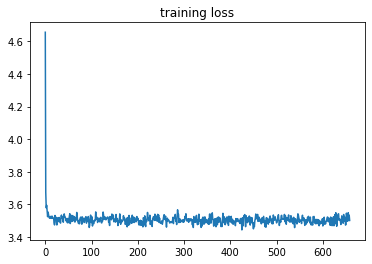

In [25]:
plt.plot(storage['losses'][5:]);
plt.title("training loss");